In [1]:
epochs = 4
train_depth = "all"
batch_size = 32
model_img_size = 299 #TODO: 224
tta = True

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import PIL
from PIL import ImageOps
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

from tqdm.auto import tqdm
tqdm.pandas()

Using TensorFlow backend.


In [3]:
!ls ../input

imet-2019-fgvc6  inceptionresnetv2


In [4]:
!ls ../input/imet-2019-fgvc6

labels.csv  sample_submission.csv  test  train	train.csv


In [5]:
train_path = "../input/imet-2019-fgvc6/train/"
test_path = "../input/imet-2019-fgvc6/test/"

In [6]:
df_train = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
df_train.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [7]:
n_rows = df_train.shape[0]
n_rows

109237

In [8]:
df_train["filename"] = df_train["id"]+".png"
df_train["path"] = [train_path]*n_rows
df_train.head()

,id,attribute_ids,filename,path
0,1000483014d91860,147 616 813,1000483014d91860.png,../input/imet-2019-fgvc6/train/
1,1000fe2e667721fe,51 616 734 813,1000fe2e667721fe.png,../input/imet-2019-fgvc6/train/
2,1001614cb89646ee,776,1001614cb89646ee.png,../input/imet-2019-fgvc6/train/
3,10041eb49b297c08,51 671 698 813 1092,10041eb49b297c08.png,../input/imet-2019-fgvc6/train/
4,100501c227f8beea,13 404 492 903 1093,100501c227f8beea.png,../input/imet-2019-fgvc6/train/


In [9]:
df_train["labels"] = df_train["attribute_ids"].apply(lambda x: x.split())
df_train.head()

,id,attribute_ids,filename,path,labels
0,1000483014d91860,147 616 813,1000483014d91860.png,../input/imet-2019-fgvc6/train/,"[147, 616, 813]"
1,1000fe2e667721fe,51 616 734 813,1000fe2e667721fe.png,../input/imet-2019-fgvc6/train/,"[51, 616, 734, 813]"
2,1001614cb89646ee,776,1001614cb89646ee.png,../input/imet-2019-fgvc6/train/,[776]
3,10041eb49b297c08,51 671 698 813 1092,10041eb49b297c08.png,../input/imet-2019-fgvc6/train/,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea,13 404 492 903 1093,100501c227f8beea.png,../input/imet-2019-fgvc6/train/,"[13, 404, 492, 903, 1093]"


In [10]:
df_labels = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
df_labels.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [11]:
df_labels.tail()

,attribute_id,attribute_name
1098,1098,tag::writing implements
1099,1099,tag::writing systems
1100,1100,tag::zeus
1101,1101,tag::zigzag pattern
1102,1102,tag::zodiac


In [12]:
n_classes = df_labels.shape[0]
n_classes

1103

In [13]:
%%time
img_sizes = []
widths = []
heights = []
aspect_ratios = []

for filename in tqdm(df_train["filename"]):
    img_path = os.path.join(train_path, filename)
    with open(img_path, 'rb') as f:
        img = PIL.Image.open(f)
        img_size = img.size
        img_sizes.append(img_size)
        widths.append(img_size[0])
        heights.append(img_size[1])
        aspect_ratios.append(img_size[0]/img_size[1])

df_train["width"] = widths
df_train["height"] = heights
df_train["aspect_ratio"] = aspect_ratios
df_train["size"] = img_sizes


CPU times: user 23 s, sys: 25.5 s, total: 48.5 s
Wall time: 3min 33s


In [14]:
df_train.head()

,id,attribute_ids,filename,path,labels,width,height,aspect_ratio,size
0,1000483014d91860,147 616 813,1000483014d91860.png,../input/imet-2019-fgvc6/train/,"[147, 616, 813]",339,300,1.130000,"(339, 300)"
1,1000fe2e667721fe,51 616 734 813,1000fe2e667721fe.png,../input/imet-2019-fgvc6/train/,"[51, 616, 734, 813]",423,300,1.410000,"(423, 300)"
2,1001614cb89646ee,776,1001614cb89646ee.png,../input/imet-2019-fgvc6/train/,[776],365,300,1.216667,"(365, 300)"
3,10041eb49b297c08,51 671 698 813 1092,10041eb49b297c08.png,../input/imet-2019-fgvc6/train/,"[51, 671, 698, 813, 1092]",300,358,0.837989,"(300, 358)"
4,100501c227f8beea,13 404 492 903 1093,100501c227f8beea.png,../input/imet-2019-fgvc6/train/,"[13, 404, 492, 903, 1093]",300,528,0.568182,"(300, 528)"


In [15]:
import gc
gc.collect()

68

In [16]:
y = np.zeros((n_rows, n_classes))
idx = 0
for label_set in df_train["labels"]:
    for label_idx in label_set:
        y[idx][int(label_idx)] = 1
    idx += 1

In [17]:
y[0][140:150]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [18]:
df_sorted = df_train.sort_values(by="aspect_ratio")

In [19]:
def show_img(filename, path):
        img = PIL.Image.open(f"{path}/{filename}")
        npa = np.array(img)
        print(npa.shape)
        #https://stackoverflow.com/questions/35902302/discarding-alpha-channel-from-images-stored-as-numpy-arrays
#        npa3 = npa[ :, :, :3]
        print(npa.shape)
        print(filename)
        plt.subplot(3, 3, 1)
        plt.imshow(npa)
#        plt.subplot(3, 3, 2)
#        plt.imshow(npa3)

In [20]:
df_sorted.head()

,id,attribute_ids,filename,path,labels,width,height,aspect_ratio,size
56558,8c386c9831f35a62,189 1059,8c386c9831f35a62.png,../input/imet-2019-fgvc6/train/,"[189, 1059]",300,7531,0.039835,"(300, 7531)"
46045,755e9dfc355f41cc,188 1035,755e9dfc355f41cc.png,../input/imet-2019-fgvc6/train/,"[188, 1035]",300,5687,0.052752,"(300, 5687)"
43370,6f778f9b79df0296,121 833,6f778f9b79df0296.png,../input/imet-2019-fgvc6/train/,"[121, 833]",300,3150,0.095238,"(300, 3150)"
83833,c8e6d135c8fb84e6,194 1034,c8e6d135c8fb84e6.png,../input/imet-2019-fgvc6/train/,"[194, 1034]",300,3015,0.099502,"(300, 3015)"
101395,ef3dec5a4d926396,396 1034,ef3dec5a4d926396.png,../input/imet-2019-fgvc6/train/,"[396, 1034]",300,3012,0.099602,"(300, 3012)"


In [21]:
df_sorted.tail()

,id,attribute_ids,filename,path,labels,width,height,aspect_ratio,size
62117,98b065f0cf47d709,1035,98b065f0cf47d709.png,../input/imet-2019-fgvc6/train/,[1035],3998,300,13.326667,"(3998, 300)"
50559,7eff1105c6bfb71e,127 597,7eff1105c6bfb71e.png,../input/imet-2019-fgvc6/train/,"[127, 597]",4080,300,13.600000,"(4080, 300)"
73509,b215f408acfe3e77,121 615 1099,b215f408acfe3e77.png,../input/imet-2019-fgvc6/train/,"[121, 615, 1099]",4428,300,14.760000,"(4428, 300)"
47102,779775a1f0d6da10,121 1099,779775a1f0d6da10.png,../input/imet-2019-fgvc6/train/,"[121, 1099]",4938,300,16.460000,"(4938, 300)"
47121,77a112100842df43,111 768,77a112100842df43.png,../input/imet-2019-fgvc6/train/,"[111, 768]",5314,300,17.713333,"(5314, 300)"


In [22]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

(7531, 300, 3)
(7531, 300, 3)
8c386c9831f35a62.png


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


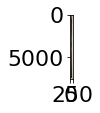

In [23]:
show_img(df_sorted.iloc[0].filename, train_path)

In [24]:
def plot_first_9(df_to_plot):
    plt.figure(figsize=[30,30])
    for x in range(9):
        path = train_path
        filename = df_to_plot.iloc[x].filename
        img = PIL.Image.open(f"{path}/{filename}")
        print(filename)
        plt.subplot(3, 3, x+1)
        plt.imshow(img)
        title_str = filename+" "+str(df_to_plot.iloc[x].aspect_ratio)
        plt.title(title_str)

8c386c9831f35a62.png
755e9dfc355f41cc.png
6f778f9b79df0296.png
c8e6d135c8fb84e6.png
ef3dec5a4d926396.png
8f84bc651353da27.png
8ee6ea818c70197c.png
5be919b2d16ab9c0.png
3857a43253d08492.png


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


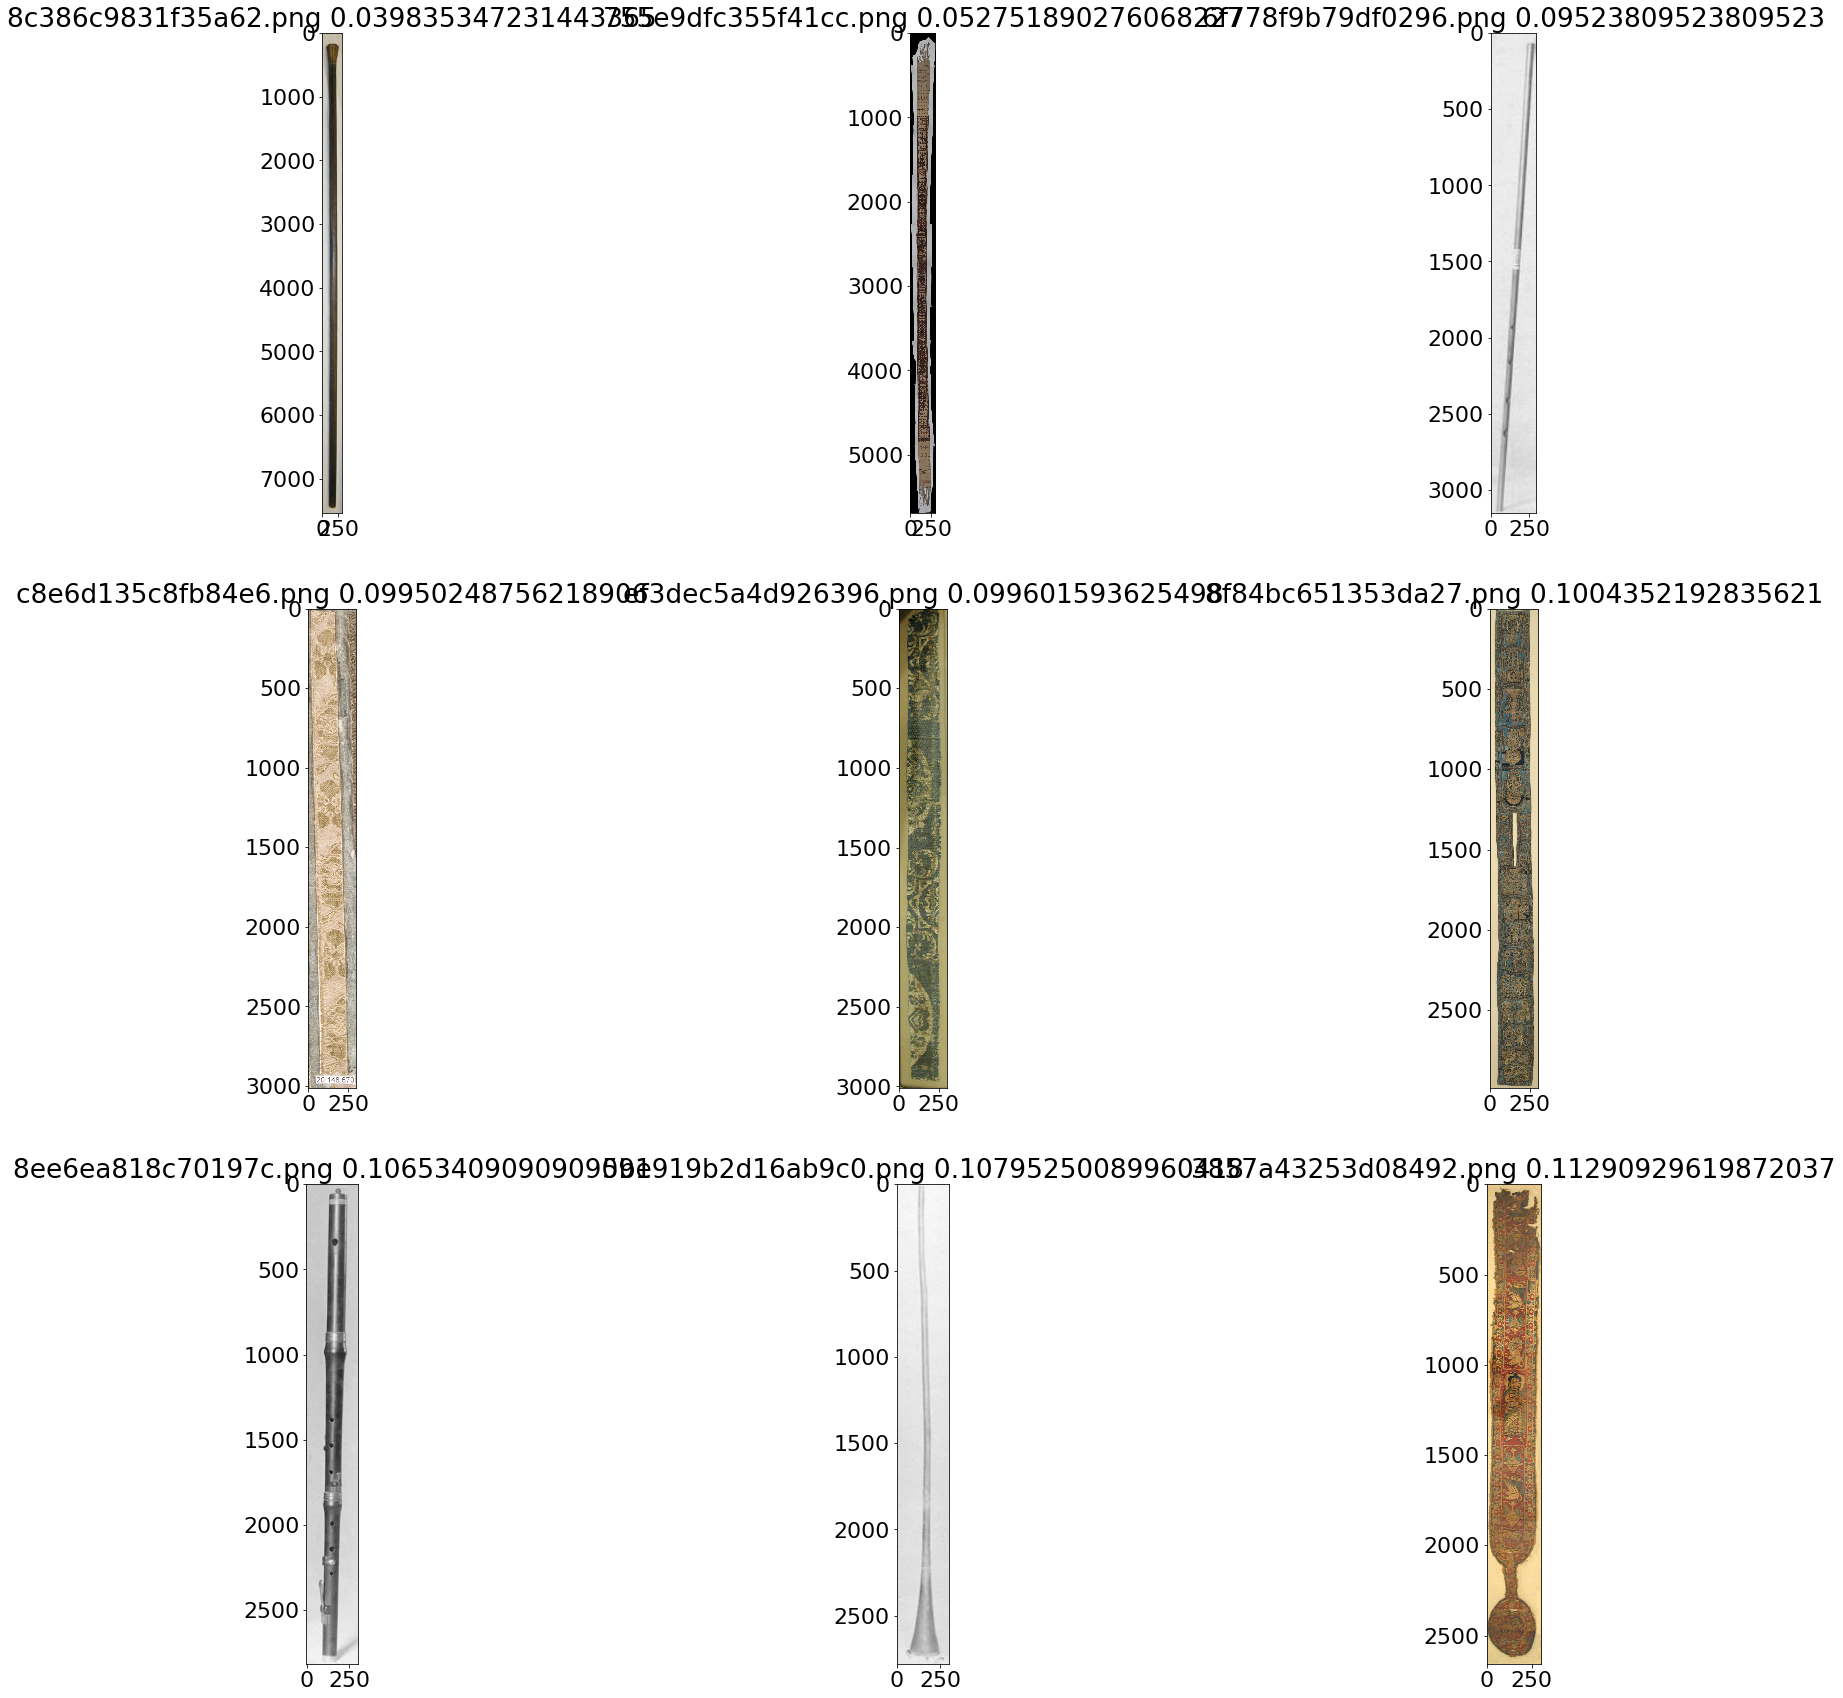

In [25]:
plot_first_9(df_sorted)

In [26]:
del df_sorted
df_sorted = df_train.sort_values(by="aspect_ratio", ascending=False)

77a112100842df43.png
779775a1f0d6da10.png
b215f408acfe3e77.png
7eff1105c6bfb71e.png
98b065f0cf47d709.png
f8706f4288c830ac.png
8f9804e15c5223c5.png
4e0cb19a44bb0eb7.png
2e13421bddca58bf.png


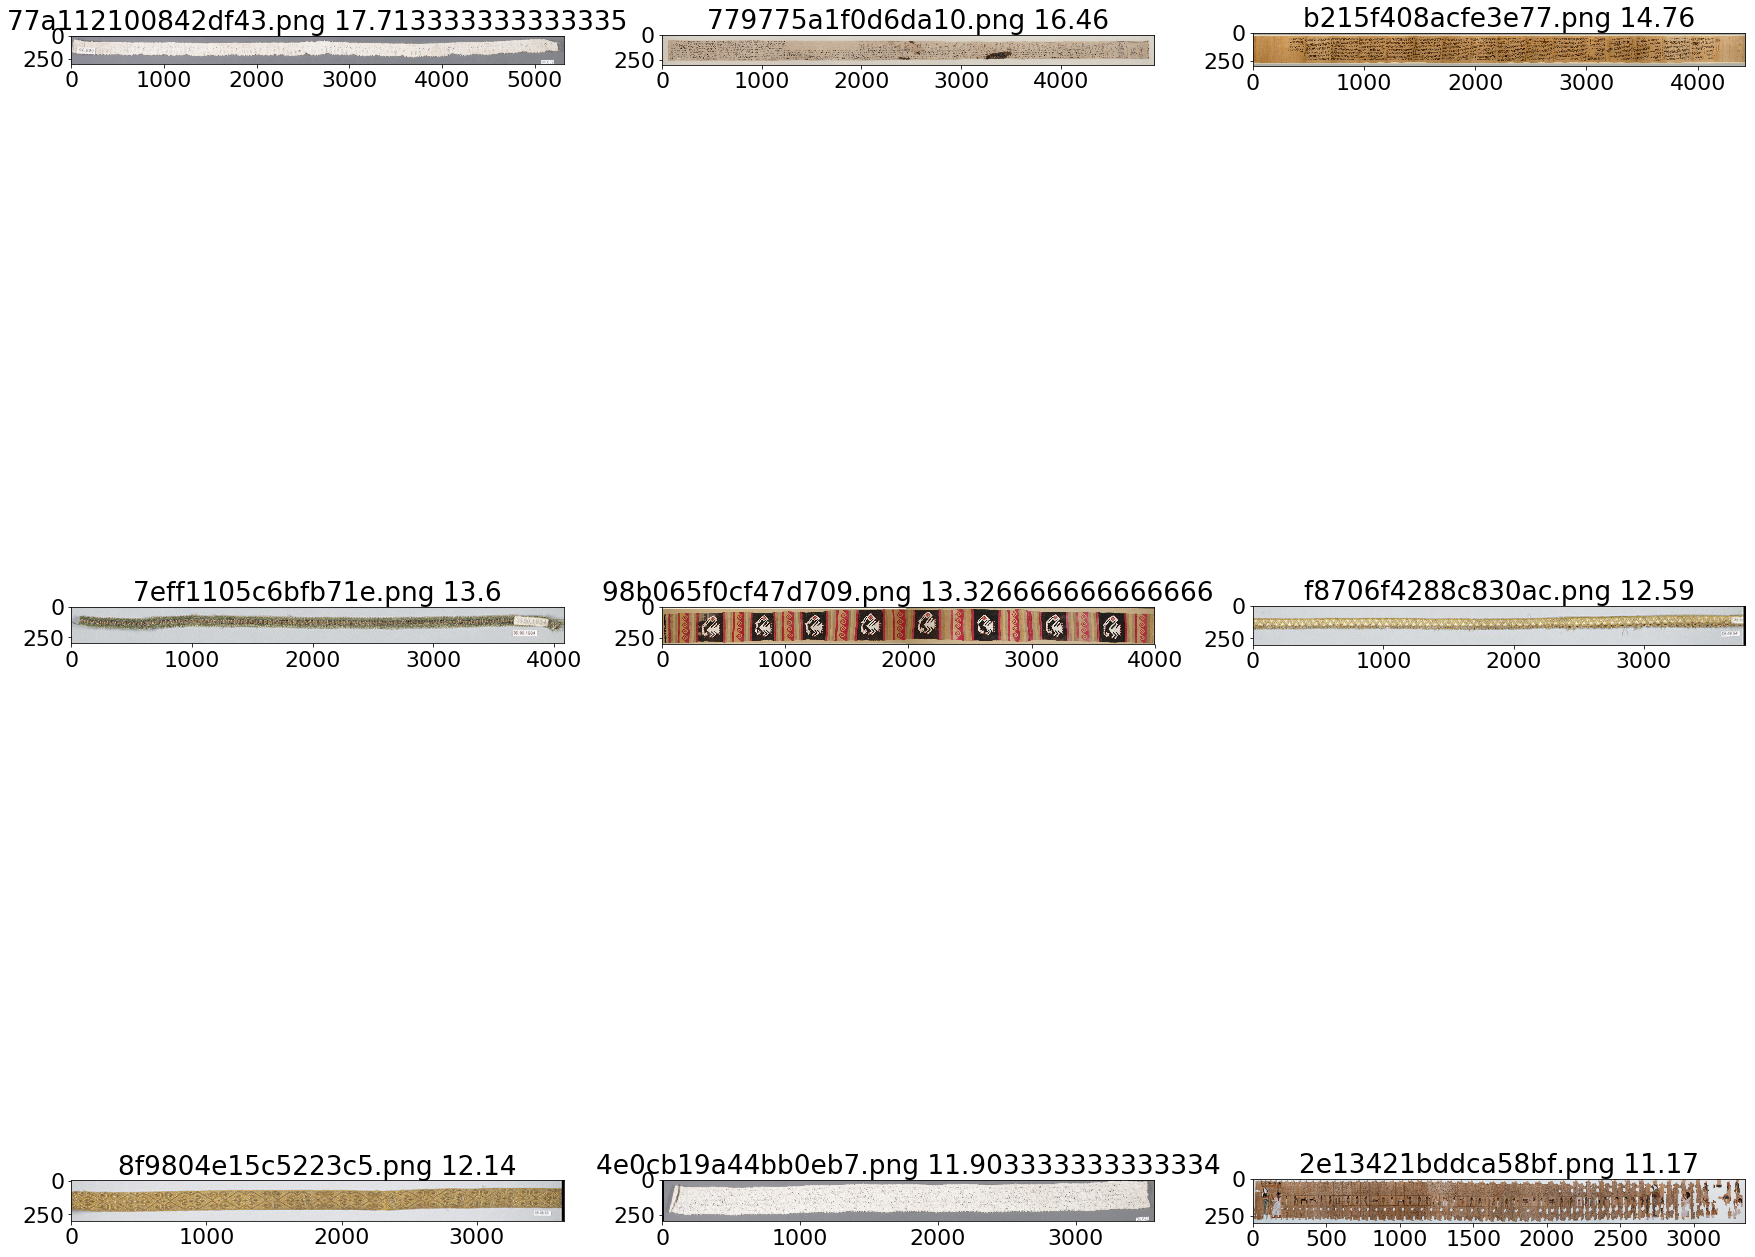

In [27]:
plot_first_9(df_sorted)

In [28]:
del df_sorted

In [29]:
from imgaug import augmenters as iaa

def img_augment(img):
    #fifty_chance = lambda aug: iaa.Sometimes(0.5, aug)
    import random
    if random.randint(1,101) > 90:
        #print("original")
        #one in 10 return original image
        return img
    seq = iaa.SomeOf(3, [
        iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        #iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 1.0 TODO: test for good values
        iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            scale=(0.8, 1.2),
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": 0}, # translate by -20 to +20 percent (per axis)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            rotate=(-10, 10), # rotate by -10 to +10 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            shear=(-5, 5), # shear by -5 to +5 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
    ])
    img = seq.augment_image(img)
    return img

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
#https://github.com/aleju/imgaug

In [30]:
df_train.head()

,id,attribute_ids,filename,path,labels,width,height,aspect_ratio,size
0,1000483014d91860,147 616 813,1000483014d91860.png,../input/imet-2019-fgvc6/train/,"[147, 616, 813]",339,300,1.130000,"(339, 300)"
1,1000fe2e667721fe,51 616 734 813,1000fe2e667721fe.png,../input/imet-2019-fgvc6/train/,"[51, 616, 734, 813]",423,300,1.410000,"(423, 300)"
2,1001614cb89646ee,776,1001614cb89646ee.png,../input/imet-2019-fgvc6/train/,[776],365,300,1.216667,"(365, 300)"
3,10041eb49b297c08,51 671 698 813 1092,10041eb49b297c08.png,../input/imet-2019-fgvc6/train/,"[51, 671, 698, 813, 1092]",300,358,0.837989,"(300, 358)"
4,100501c227f8beea,13 404 492 903 1093,100501c227f8beea.png,../input/imet-2019-fgvc6/train/,"[13, 404, 492, 903, 1093]",300,528,0.568182,"(300, 528)"


In [31]:
df_train[df_train["aspect_ratio"] > 2].shape

(4536, 9)

In [32]:
df_train[df_train["aspect_ratio"] < 0.5].shape

(4039, 9)

In [33]:
from keras.applications import resnet50
from keras.applications import inception_resnet_v2
import random

def img_pad_resize(filename, input_path, augment):
    img_meta = df_train[df_train["filename"] == filename].iloc[0]
    #print(img_meta)
    img = PIL.Image.open(f'{input_path}/{filename}')

    cropped = False
    if random.randint(1,101) > 50:
        aspect_ratio = img_meta["aspect_ratio"]
        if aspect_ratio > 2 or aspect_ratio < 0.5:
            img_w = img_meta["width"]
            img_h = img_meta["height"]
            diff = abs(img_w-img_h)
            if img_w > img_h:
                shorter = "height"
                larger = "width"
                crop_y = 0
                crop_x = random.randint(0, diff)
            else:
                shorter = "width"
                larger = "height"
                crop_x = 0
                crop_y = random.randint(0, diff)
            crop_size = img_meta[shorter]
            img_cropped = img.crop((crop_x, crop_y, crop_x+crop_size, crop_y+crop_size))
            img.close()
            img = img_cropped
            cropped = True
            #print("cropped:"+filename)
       
    w = img.size[0]
    h = img.size[1]
    pad_size = np.abs(h-w)
    wm = hm = 1
    pw = ph = 0
    if w < h:
        wm = h / w
        pw = pad_size / 2
    else:
        hm = w / h
        ph = pad_size / 2
    w *= wm
    h *= hm
    h = int(h)
    w = int(w)
    pw = int(pw)
    ph = int(ph)
    padding = (pw, ph, pw, ph)
    padded = ImageOps.expand(img, padding)
    resized = padded.resize((model_img_size, model_img_size))
    np_img = np.array(resized)
    img.close()
    padded.close()
    del img
    del padded
    if augment:
        np_img = img_augment(np_img)
    np_img = inception_resnet_v2.preprocess_input(np_img)
    return np_img

(300, 615, 3)
(300, 615, 3)
e295ca08e62838e0.png


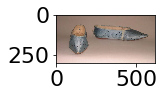

In [34]:
show_img("e295ca08e62838e0.png", train_path)

In [35]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a.iloc[p], b[p]

In [36]:
from skimage.io import imread
from skimage.transform import resize
from keras.utils import Sequence

#https://github.com/sdcubber/Keras-Sequence-boilerplate/blob/master/Keras-Sequence.ipynb
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class MySequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, mode="train", augment=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.mode = mode
        self.max_idx = math.ceil(len(x_set)/batch_size)
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx2 = idx % self.max_idx
        #i guess the len method above stops the generator from being called too much
        #print(f"idx:{idx}, idx2:{idx2}")
        start = idx * self.batch_size
        end = min(start + batch_size, len(self.x))
        batch_x = self.x.iloc[start : end]
        batch_y = self.y[start : end]
        
        next_batch = []
        for index, row in batch_x.iterrows():
            file_name = row["filename"]
            file_path = row["path"]
            padded = img_pad_resize(file_name, file_path, self.augment)
            if padded.shape != (299, 299, 3):
                print(f"shape mismatch {file_name}, {file_path}, {padded.shape}")
                print()
                #the image has alpha channel, drop it
                padded = padded[ :, :, :3]
            
            next_batch.append(padded)
        np_y = np.array(batch_y)
        result = np.array(next_batch), np_y

        #print(result[0].shape)
        return result

    def on_epoch_end(self):
        self.x, self.y = unison_shuffled_copies(self.x, self.y)

In [37]:
from sklearn.model_selection import train_test_split

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
indexes = np.arange(df_train.shape[0])
train_indices, valid_indices = train_test_split(indexes, test_size=0.10, random_state=8)
#                                               stratify=y)

In [38]:
train_sub_df = df_train.iloc[train_indices]
train_sub_y = y[train_indices]
valid_sub_df = df_train.iloc[valid_indices]
valid_sub_y = y[valid_indices]
#train_gen = MySequence(train_sub_df, train_sub_df["breed_label"], batch_size)
#valid_gen = MySequence(valid_sub_df, valid_sub_df["breed_label"], batch_size)
warmup_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=False)
#TODO: remove probability of no augment from generator?
train_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=True)
valid_gen = MySequence(valid_sub_df, valid_sub_y, batch_size, augment=False)

In [39]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
checkpoint = ModelCheckpoint('../working/Resnet50_best_{epoch:03d}_{val_loss:.2f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [40]:
def plot_gen_batch(idx):
    # configure batch size and retrieve one batch of images
    plt.clf() #clears matplotlib data and axes
    #for batch in train_generator:
    rows = batch_size / 3
    plt.figure(figsize=[30,10*rows])
    batch = train_gen.__getitem__(idx)
    for x in range(0,batch_size-1):
    #    print(train_generator.filenames[x])
        plt.subplot(rows, 3, x+1)
        plt.imshow(batch[0][x], interpolation='nearest')

        item_labels = np.argwhere(batch[1][x] > 0)
        title_val = []
        print(item_labels)
        for tag_id in item_labels:
            att_name = df_labels[df_labels['attribute_id'] == tag_id[0]]
            print(att_name["attribute_name"]) #att_name is a dataframe
            title_val.append(att_name['attribute_name'].iloc[0]) #i
        plt.title(title_val)

    plt.show()

In [41]:
#plot_gen_batch(0)

In [42]:
!ls ../input/inceptionresnetv2

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5


In [43]:
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2

def create_model(trainable_layer_count):
    input_tensor = Input(shape=(model_img_size, model_img_size, 3))
    base_model = InceptionResNetV2(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
#    base_model = ResNet50(include_top=False,
#                          #the weights value can apparently also be a file path..
#                   weights=None, #loading weights from dataset, avoiding need for internet conn
#                   input_tensor=input_tensor)
#    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if trainable_layer_count == "all":
        for layer in base_model.layers:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layer_count:]:
            layer.trainable = True
    print("base model has {} layers".format(len(base_model.layers)))
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
#     x = Flatten()(x)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)
    #predict individual probability of each category
    final_output = Dense(n_classes, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [44]:
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [45]:
def f2_score(y_true, y_pred):
    print(f"y_true="+str(y_true[0]))
    print(f"y_pred={y_pred}")
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    result = K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    print(result)
    return result



In [46]:
beta_f2=2

def my_f2(y_true, y_pred):
    print(f"y_true="+str(y_true[0]))
    print(f"y_pred={y_pred}")
#    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1), axis=1)
    tn = np.sum((y_true == 0) & (y_pred == 0), axis=1)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=1)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return np.mean(f2)

In [47]:
from sklearn.metrics import fbeta_score

#https://www.kaggle.com/anokas/fixed-f2-score-in-python
def my_my_f2(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')


In [48]:
model = create_model(train_depth)


Instructions for updating:
Colocations handled automatically by placer.
base model has 780 layers
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [49]:
1e-04

0.0001

In [50]:
from keras.optimizers import Adam
#f2_score = my_f2

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=["accuracy", f2_score]) #loss=focal_loss


y_true=Tensor("metrics/f2_score/strided_slice:0", shape=(?,), dtype=float32)
y_pred=Tensor("final_output/Sigmoid:0", shape=(?, 1103), dtype=float32)
Tensor("metrics/f2_score/Mean:0", shape=(), dtype=float32)


In [51]:
#train_steps = 2*len(train_indices)/batch_size
#valid_steps = 2*len(valid_indices)/batch_size
train_steps = len(train_indices)/batch_size
valid_steps = len(valid_indices)/batch_size
fit_history = model.fit_generator(
        warmup_gen,
        steps_per_epoch=train_steps,
        epochs = 2,
        use_multiprocessing=True,
        workers=2,
        callbacks=[], #no callbacks for warmup
    verbose = 1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
3073/3072 [==============================] - 2681s 872ms/step - loss: 0.0216 - acc: 0.9968 - f2_score: 0.0235
Epoch 2/2
3073/3072 [==============================] - 2592s 843ms/step - loss: 0.0143 - acc: 0.9972 - f2_score: 0.0542


In [52]:
#was thinking to save weights, compile new params, load weights. 
#apparently compiling the model does not affect weights so no need
#https://stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow
#model.save_weights('resnet50_warmup.h5')

In [53]:
from keras.optimizers import Adam
#f2_score = my_f2
#https://datascience.stackexchange.com/questions/26112/decay-parameter-in-keras-optimizers
model.compile(optimizer=Adam(lr=0.0001, decay=0.0001), loss='binary_crossentropy', metrics=["accuracy", f2_score]) #loss=focal_loss


y_true=Tensor("metrics_1/f2_score/strided_slice:0", shape=(?,), dtype=float32)
y_pred=Tensor("final_output/Sigmoid:0", shape=(?, 1103), dtype=float32)
Tensor("metrics_1/f2_score/Mean:0", shape=(), dtype=float32)


In [54]:
#again, no need to re-load weights after compiling since compile has no effect on weights
#model.load_weights('resnet50_warmup.h5')

In [55]:
#train_steps = 2*len(train_indices)/batch_size
#valid_steps = 2*len(valid_indices)/batch_size
train_steps = len(train_indices)/batch_size
valid_steps = len(valid_indices)/batch_size
fit_history = model.fit_generator(
        train_gen,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=valid_gen,
        validation_steps=valid_steps,
        use_multiprocessing=True,
        workers=2,
        callbacks=callbacks_list,
    verbose = 1
)

Epoch 1/4
3073/3072 [==============================] - 3218s 1s/step - loss: 0.0121 - acc: 0.9973 - f2_score: 0.0982 - val_loss: 0.0115 - val_acc: 0.9973 - val_f2_score: 0.1216

Epoch 00001: val_loss improved from inf to 0.01150, saving model to ../working/Resnet50_best_001_0.01.h5
Epoch 2/4
3073/3072 [==============================] - 3096s 1s/step - loss: 0.0116 - acc: 0.9973 - f2_score: 0.1226 - val_loss: 0.0112 - val_acc: 0.9974 - val_f2_score: 0.1540

Epoch 00002: val_loss improved from 0.01150 to 0.01116, saving model to ../working/Resnet50_best_002_0.01.h5
Epoch 3/4
3073/3072 [==============================] - 3091s 1s/step - loss: 0.0113 - acc: 0.9973 - f2_score: 0.1406 - val_loss: 0.0109 - val_acc: 0.9974 - val_f2_score: 0.1720

Epoch 00003: val_loss improved from 0.01116 to 0.01088, saving model to ../working/Resnet50_best_003_0.01.h5
Epoch 4/4
2259/3072 [=====================>........] - ETA: 12:42 - loss: 0.0111 - acc: 0.9974 - f2_score: 0.1560

In [56]:
def plot_loss_and_accuracy(fit_history):
    plt.clf()
    plt.plot(fit_history.history['f2_score'])
    plt.plot(fit_history.history['val_f2_score'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    # summarize history for loss
    plt.plot(fit_history.history['loss'])
    plt.plot(fit_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

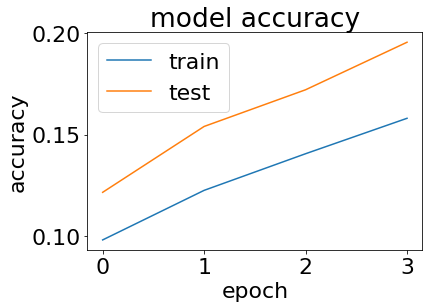

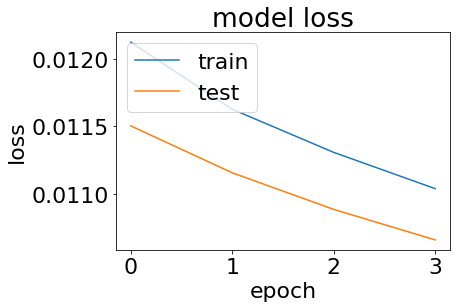

In [57]:
plot_loss_and_accuracy(fit_history)

In [58]:
pd.DataFrame(fit_history.history).head(20)

,val_loss,val_acc,val_f2_score,loss,acc,f2_score,lr
0,0.011503,0.997328,0.121589,0.012123,0.997264,0.098186,0.0001
1,0.011155,0.997377,0.153967,0.011627,0.997310,0.122553,0.0001
2,0.010884,0.997418,0.172003,0.011307,0.997348,0.140561,0.0001
3,0.010658,0.997448,0.195367,0.011038,0.997384,0.157979,0.0001


np.set_printoptions(suppress=True)
predictions = []
for filename in tqdm(valid_sub_df["filename"]):
    img = PIL.Image.open(f'{train_path}/{filename}')
    resized = img.resize((model_img_size, model_img_size))
    np_img = np.array(resized)
    score_predict = model.predict(resnet50.preprocess_input(np_img[np.newaxis]))
    predictions.append(score_predict)

In [59]:
%%time

np.set_printoptions(suppress=True)
predictions = []
printed = 0
for filename in tqdm(valid_sub_df["filename"]):
    np_img = img_pad_resize(filename, train_path, False)
    if tta:
        img_pred = np.zeros(n_classes)
        for x in range(10):
            aug_img = img_augment(np_img)
            #img_augment already runs resnet50.preprocess_input
            score_predict = model.predict(aug_img[np.newaxis])
            img_pred += np.squeeze(score_predict)
        img_pred /= 10
        score_predict = img_pred
    else:
        score_predict = model.predict(resnet50.preprocess_input(np_img[np.newaxis]))
    if printed < 10:
        printed += 1
        print(score_predict)
    predictions.append(score_predict)
#    label_predict = np.arange(n_classes)[score_predict[0]>=best_thr]
    # print(label_predict)
#    str_predict_label = ' '.join(str(l))

[0.00002549 0.00005211 0.00000906 ... 0.00011136 0.00032556 0.00022559]
[0.00002888 0.00010959 0.00001193 ... 0.00035012 0.00020829 0.00027119]
[0.000003   0.00100448 0.0007994  ... 0.00011454 0.0004106  0.00011037]
[0.00001588 0.00673591 0.00103971 ... 0.00016163 0.00015457 0.00007064]
[0.00000707 0.00003349 0.00001219 ... 0.00002292 0.00035471 0.00033854]
[0.00002251 0.00003952 0.00005193 ... 0.00016529 0.00183167 0.00057703]
[0.00002389 0.00005134 0.00000826 ... 0.00020066 0.00034823 0.00010173]
[0.00082837 0.00563237 0.0001073  ... 0.00002412 0.00096144 0.00008878]
[0.00000334 0.00001623 0.00000456 ... 0.00014595 0.00006776 0.00027327]
[0.00139375 0.00116929 0.0000467  ... 0.00008138 0.00167824 0.00022025]


In [60]:
np.array(predictions)

array([[0.00002549, 0.00005211, 0.00000906, ..., 0.00011136, 0.00032556,
        0.00022559],
       [0.00002888, 0.00010959, 0.00001193, ..., 0.00035012, 0.00020829,
        0.00027119],
       [0.000003  , 0.00100448, 0.0007994 , ..., 0.00011454, 0.0004106 ,
        0.00011037],
       ...,
       [0.00002432, 0.00116051, 0.0008444 , ..., 0.0001354 , 0.00040193,
        0.00015768],
       [0.00000043, 0.00000172, 0.00000095, ..., 0.00002946, 0.00001924,
        0.00010588],
       [0.00004959, 0.06755882, 0.0000203 , ..., 0.00000126, 0.00000795,
        0.00000029]])

In [61]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    preds = preds.squeeze()
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

In [62]:
preds = predictions[0]
thr = 0.3
aa = (preds > thr).astype(int)
sum(aa)

0

In [63]:
valid_sub_y.shape

(10924, 1103)

In [64]:
preds = np.array(predictions)
(preds > thr).astype(int).squeeze().shape

(10924, 1103)

In [65]:
y_true_row = valid_sub_y[0]
y_pred_row = predictions[0]
np.sum((y_true_row == 1) & (y_pred_row == 1))


0

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



thr=0.080 F2=0.432


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


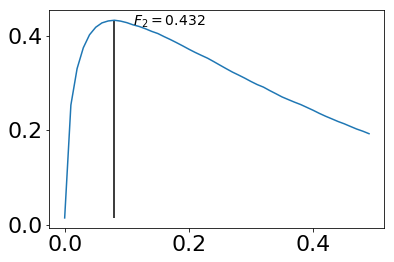

In [66]:
best_thr, best_score = find_best_fixed_threshold(np.array(predictions), valid_sub_y)

In [67]:
%%time

predicted = []
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

for name in tqdm(submit['id']):
    np_img = img_pad_resize(name+".png", test_path, False)
#    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
#    img = PIL.Image.open(path+".png")
#    resized = img.resize((model_img_size, model_img_size))
#    np_img = np.array(resized)
    if tta:
        img_pred = np.zeros(n_classes)
        for x in range(10):
            aug_img = img_augment(np_img)
            #img_augment already runs resnet50.preprocess_input
            score_predict = model.predict(aug_img[np.newaxis])
            img_pred += np.squeeze(score_predict)
        img_pred /= 10
        score_predict = img_pred
    else:
        score_predict = model.predict(resnet50.preprocess_input(np_img[np.newaxis]))
    label_predict = score_predict>=best_thr
    label_predict = label_predict.astype(int)
    label_predict = np.argwhere(label_predict == 1).flatten()
    # print(label_predict)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

IndexError: single positional indexer is out-of-bounds

In [68]:
label_predict

NameError: name 'label_predict' is not defined

In [69]:
score_predict[0]

4.958510398864746e-05

In [70]:

submit['attribute_ids'] = predicted
submit.to_csv('submission.csv', index=False)

ValueError: Length of values does not match length of index

In [71]:
submit.head()

,id,attribute_ids
0,10023b2cc4ed5f68,0 1 2
1,100fbe75ed8fd887,0 1 2
2,101b627524a04f19,0 1 2
3,10234480c41284c6,0 1 2
4,1023b0e2636dcea8,0 1 2
